In [3]:
import cv2
import numpy as np
import torch
from datetime import datetime
import matplotlib.pyplot as plt

image_path = "./data/sample.jpg"

### YOLO


0: 640x416 1 person, 38.4ms
Speed: 2.7ms preprocess, 38.4ms inference, 6.4ms postprocess per image at shape (1, 3, 640, 416)


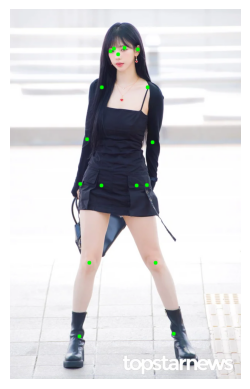

소요시간: 0:00:00.352071


In [16]:
from ultralytics import YOLO

# 📌 YOLO-Pose 모델 로드
yolo_model = YOLO("yolov8n-pose.pt")

# 📌 이미지 로드
image = cv2.imread(image_path)

if image is None:
    print(f"Error: Cannot load image from {image_path}")
    exit()

start = datetime.now()  ### 속도 확인 ###

# 📌 YOLO-Pose 모델을 사용하여 포즈 감지
results = yolo_model(image)

# 📌 관절(Keypoints) 좌표 추출 및 시각화
for result in results:
    keypoints = result.keypoints.xy.cpu().numpy()  # 좌표 변환
    scores = result.keypoints.conf.cpu().numpy()  # 신뢰도 변환

    for kp, score in zip(keypoints[0], scores[0]):
        if score > 0.5:  # 신뢰도 50% 이상
            x, y = int(kp[0]), int(kp[1])
            cv2.circle(image, (x, y), 5, (0, 255, 0), -1)  # 녹색 점으로 표시

# 📌 시각화된 이미지 출력
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

print("소요시간:", datetime.now() - start)  ### 속도 확인 ###


### OpenPose - 보류
- openpose는 일반적인 pip install로 설치할 수 있는 패키지가 아님
- OpenPose는 C++ 기반으로 작성되어 있으며, 직접 빌드 후 Python API를 사용해야 함
- 일단 보류 

### PoseNet 

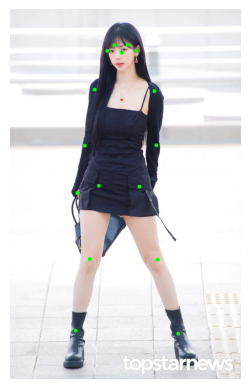

소요시간: 0:00:00.465958


In [17]:
import cv2
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

image_path = "./data/sample.jpg"

# 📌 MoveNet 모델 로드
movenet = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
model = movenet.signatures["serving_default"]

# 📌 이미지 로드
image = cv2.imread(image_path)
if image is None:
    print(f"Error: Cannot load image from {image_path}")
    exit()

# 원본 이미지 복사
image_copy = image.copy()
h, w = image.shape[:2]

start = datetime.now()  ### 속도 확인 ###

# 📌 1. 이미지 리사이징 (192x192) + 패딩 고려
def resize_with_padding(image, target_size=192):
    h, w = image.shape[:2]
    scale = target_size / max(h, w)  # 가장 긴 변 기준 스케일 계산
    new_w, new_h = int(w * scale), int(h * scale)
    resized_image = cv2.resize(image, (new_w, new_h))

    # 패딩 추가 (가로/세로 중 짧은 쪽)
    pad_w = (target_size - new_w) // 2
    pad_h = (target_size - new_h) // 2
    
    padded_image = cv2.copyMakeBorder(
        resized_image, pad_h, target_size - new_h - pad_h, 
        pad_w, target_size - new_w - pad_w, 
        cv2.BORDER_CONSTANT, value=(255, 255, 255)
    )
    return padded_image, scale, pad_w, pad_h, new_w, new_h

padded_image, scale, pad_w, pad_h, new_w, new_h = resize_with_padding(image)

# MoveNet 입력 형식 맞추기
input_image = np.expand_dims(padded_image, axis=0)
input_image = tf.convert_to_tensor(input_image, dtype=tf.int32)

# 📌 2. 모델 실행
outputs = model(input_image)
keypoints_with_scores = outputs["output_0"].numpy()[0, 0, :, :]  # (17, 3)

# 📌 3. 좌표 변환 및 필터링
threshold = 0.5  # 신뢰도 기준

# keypoints 순서: (y, x, conf)
for i, (y, x, conf) in enumerate(keypoints_with_scores):
    if conf > threshold:
        # 정규화된 좌표(0~1)를 패딩 고려하여 원본 이미지 크기로 변환
        x_coord = int(((x * 192) - pad_w) / scale)  # 가로 (width) 변환
        y_coord = int(((y * 192) - pad_h) / scale)  # 세로 (height) 변환
        
        # 이미지 내에 좌표가 있는지 확인 후 표시
        if 0 <= x_coord < w and 0 <= y_coord < h:
            cv2.circle(image_copy, (x_coord, y_coord), 5, (0, 255, 0), -1)

# 📌 4. 시각화된 이미지 출력
plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

print("소요시간:", datetime.now() - start)  ### 속도 확인 ###


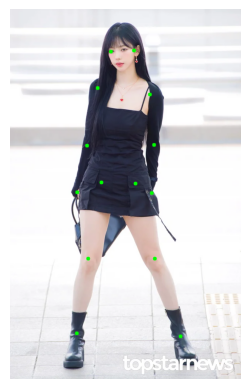

소요시간: 0:00:00.444139


In [18]:
### 패딩 안넣고 진행

import tensorflow as tf
import tensorflow_hub as hub


# 📌 MoveNet 모델 로드
movenet = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
model = movenet.signatures["serving_default"]

# 📌 이미지 로드
image = cv2.imread(image_path)
if image is None:
    print(f"Error: Cannot load image from {image_path}")
    exit()

# 원본 이미지 복사 및 크기 정보 저장
image_copy = image.copy()
orig_h, orig_w = image.shape[:2]

start = datetime.now()  ### 속도 확인 ###

# 📌 1. 이미지 리사이즈 (패딩 없이 192x192로 변환)
resized_image = cv2.resize(image, (192, 192))

# MoveNet 입력 형식 맞추기
input_image = np.expand_dims(resized_image, axis=0)
input_image = tf.convert_to_tensor(input_image, dtype=tf.int32)

# 📌 2. 모델 실행
outputs = model(input_image)
keypoints_with_scores = outputs["output_0"].numpy()[0, 0, :, :]  # (17, 3)

# 📌 3. 좌표 변환 및 필터링
threshold = 0.5  # 신뢰도 기준

# keypoints 순서: (y, x, score)
for i, (y, x, conf) in enumerate(keypoints_with_scores):
    if conf > threshold:
        # 정규화된 좌표(0~1)를 원본 이미지 크기로 변환
        x_coord = int(x * orig_w)
        y_coord = int(y * orig_h)
        
        # 이미지 내에 좌표가 있는지 확인 후 표시
        if 0 <= x_coord < orig_w and 0 <= y_coord < orig_h:
            cv2.circle(image_copy, (x_coord, y_coord), 5, (0, 255, 0), -1)

# 📌 4. 시각화된 이미지 출력
plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

print("소요시간:", datetime.now() - start)  ### 속도 확인 ###


### HRNet - 보류
- C++ 컴파일러 필요
- 일단 보류 

In [8]:
import torch
print(torch.version.cuda)


12.1


### ViTPose
- Bounding Box가 있어야 사람의 포즈를 정확히 인식

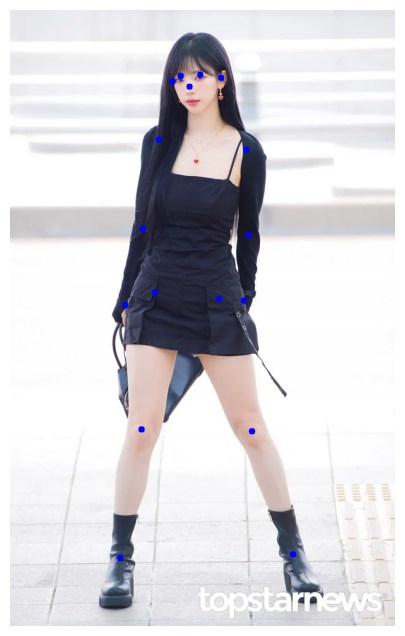

소요시간: 0:00:00.358060


In [20]:
import torch
import requests
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

from transformers import (
    AutoProcessor,
    RTDetrForObjectDetection,
    VitPoseForPoseEstimation,
)

# 📌 디바이스 설정 (CUDA 사용 가능 여부 확인)
device = "cuda" if torch.cuda.is_available() else "cpu"

# 📌 이미지 로드 (경로 설정)
image_path = "./data/sample.jpg"  # 로컬 파일 사용
image_pil = Image.open(image_path).convert("RGB")  # PIL 형식으로 로드

# 📌 OpenCV를 위한 이미지 변환 (PIL → OpenCV)
image_cv = np.array(image_pil)
image_cv = cv2.cvtColor(image_cv, cv2.COLOR_RGB2BGR)  # OpenCV는 BGR 사용

# ------------------------------------------------------------------------
# **1️⃣ Stage 1: 사람 탐지 (RT-DETR)**
# ------------------------------------------------------------------------

# 📌 객체 탐지 모델 로드
person_image_processor = AutoProcessor.from_pretrained("PekingU/rtdetr_r50vd_coco_o365")
person_model = RTDetrForObjectDetection.from_pretrained("PekingU/rtdetr_r50vd_coco_o365").to(device)


# 📌 포즈 추정 모델 로드
pose_processor = AutoProcessor.from_pretrained("usyd-community/vitpose-plus-base")
pose_model = VitPoseForPoseEstimation.from_pretrained("usyd-community/vitpose-plus-base").to(device)

start = datetime.now()  ### 속도 확인 ###

# 📌 이미지 전처리
inputs = person_image_processor(images=image_pil, return_tensors="pt").to(device)

# 📌 추론 실행
with torch.no_grad():
    outputs = person_model(**inputs)

# 📌 결과 후처리
results = person_image_processor.post_process_object_detection(
    outputs, target_sizes=torch.tensor([(image_pil.height, image_pil.width)]), threshold=0.3
)
result = results[0]  # 첫 번째 이미지 결과

# 📌 COCO 데이터셋에서 '사람' 클래스는 index 0
person_boxes = result["boxes"][result["labels"] == 0]

# **Bounding Box 변환 (VOC -> COCO)**
if person_boxes.shape[0] > 0:  # 사람이 검출된 경우만 실행
    person_boxes = person_boxes.cpu().numpy()
    person_boxes[:, 2] -= person_boxes[:, 0]
    person_boxes[:, 3] -= person_boxes[:, 1]

# ------------------------------------------------------------------------
# **2️⃣ Stage 2: 포즈 추정 (ViTPose)**
# ------------------------------------------------------------------------

# 📌 사람이 감지된 경우만 포즈 추정 수행
if person_boxes.shape[0] > 0:
    inputs = pose_processor(images=image_pil, boxes=[person_boxes], return_tensors="pt").to(device)
    inputs["dataset_index"] = torch.tensor([0], device=device)  # ViTPose의 MOE 구조 대응

    with torch.no_grad():
        outputs = pose_model(**inputs)

    # 📌 결과 후처리
    pose_results = pose_processor.post_process_pose_estimation(outputs, boxes=[person_boxes], threshold=0.3)
    image_pose_result = pose_results[0]  # 첫 번째 이미지 결과
else:
    image_pose_result = []

# ------------------------------------------------------------------------
# **3️⃣ 시각화 (Keypoints 표시)**
# ------------------------------------------------------------------------

# 📌 Keypoints 그리기
for person_pose in image_pose_result:
    for keypoint, label, score in zip(
        person_pose["keypoints"], person_pose["labels"], person_pose["scores"]
    ):
        if score > 0.5:  # 신뢰도 50% 이상인 경우만 표시
            x, y = map(int, keypoint)
            cv2.circle(image_cv, (x, y), 5, (255, 0, 0), -1)  # 파란색 점

# 📌 시각화된 이미지 출력
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

print("소요시간:", datetime.now() - start)  ### 속도 확인 ###


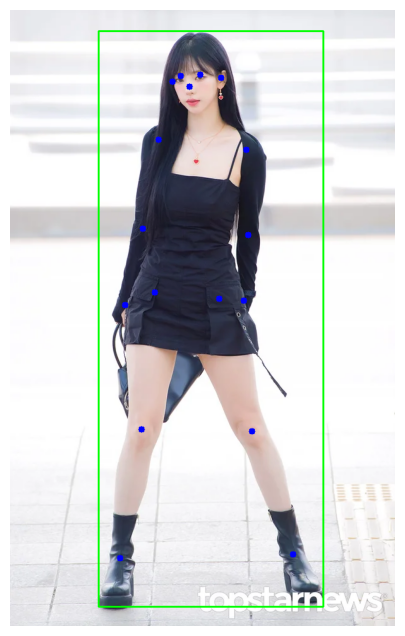

소요시간: 0:00:00.338068


In [ ]:
import torch
import requests
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

from transformers import (
    AutoProcessor,
    RTDetrForObjectDetection,
    VitPoseForPoseEstimation,
)

# 📌 디바이스 설정 (CUDA 사용 가능 여부 확인)
device = "cuda" if torch.cuda.is_available() else "cpu"

# 📌 이미지 로드 (경로 설정)
image_path = "./data/sample.jpg"  # 로컬 파일 사용
image_pil = Image.open(image_path).convert("RGB")  # PIL 형식으로 로드

# 📌 OpenCV를 위한 이미지 변환 (PIL → OpenCV)
image_cv = np.array(image_pil)
image_cv = cv2.cvtColor(image_cv, cv2.COLOR_RGB2BGR)  # OpenCV는 BGR 사용

# ------------------------------------------------------------------------
# **1️⃣ Stage 1: 사람(Bounding Box) 탐지 (RT-DETR)**
# ------------------------------------------------------------------------

# 📌 객체 탐지 모델 로드
person_image_processor = AutoProcessor.from_pretrained("PekingU/rtdetr_r50vd_coco_o365")
person_model = RTDetrForObjectDetection.from_pretrained("PekingU/rtdetr_r50vd_coco_o365").to(device)

# 📌 포즈 추정 모델 로드
pose_processor = AutoProcessor.from_pretrained("usyd-community/vitpose-plus-base")
pose_model = VitPoseForPoseEstimation.from_pretrained("usyd-community/vitpose-plus-base").to(device)

start = datetime.now()  ### 속도 확인 ###

# 📌 이미지 전처리
inputs = person_image_processor(images=image_pil, return_tensors="pt").to(device)

# 📌 추론 실행
with torch.no_grad():
    outputs = person_model(**inputs)

# 📌 결과 후처리
results = person_image_processor.post_process_object_detection(
    outputs, target_sizes=torch.tensor([(image_pil.height, image_pil.width)]), threshold=0.3
)
result = results[0]  # 첫 번째 이미지 결과

# 📌 COCO 데이터셋에서 '사람' 클래스는 index 0
person_boxes = result["boxes"][result["labels"] == 0]

# **Bounding Box 변환 (VOC -> COCO)**
# VOC 형식: (x1, y1, x2, y2) → COCO 형식: (x, y, width, height)
if person_boxes.shape[0] > 0:  # 사람이 검출된 경우만 실행
    person_boxes = person_boxes.cpu().numpy()
    person_boxes[:, 2] -= person_boxes[:, 0]
    person_boxes[:, 3] -= person_boxes[:, 1]

# ------------------------------------------------------------------------
# **2️⃣ Stage 2: 포즈 추정 (ViTPose)**
# ------------------------------------------------------------------------


# 📌 사람이 감지된 경우만 포즈 추정 수행
if person_boxes.shape[0] > 0:
    inputs = pose_processor(images=image_pil, boxes=[person_boxes], return_tensors="pt").to(device)
    inputs["dataset_index"] = torch.tensor([0], device=device)  # ViTPose의 MOE 구조 대응

    with torch.no_grad():
        outputs = pose_model(**inputs)

    # 📌 결과 후처리
    pose_results = pose_processor.post_process_pose_estimation(outputs, boxes=[person_boxes], threshold=0.3)
    image_pose_result = pose_results[0]  # 첫 번째 이미지 결과
else:
    image_pose_result = []

# ------------------------------------------------------------------------
# **3️⃣ 시각화 (Bounding Box 및 Keypoints 표시)**
# ------------------------------------------------------------------------

# 📌 Bounding Box 그리기
for box in person_boxes:
    x, y, w, h = map(int, box)
    cv2.rectangle(image_cv, (x, y), (x + w, y + h), (0, 255, 0), 2)  # 초록색 박스

# 📌 Keypoints 그리기
for person_pose in image_pose_result:
    for keypoint, label, score in zip(
        person_pose["keypoints"], person_pose["labels"], person_pose["scores"]
    ):
        if score > 0.5:  # 신뢰도 50% 이상인 경우만 표시
            x, y = map(int, keypoint)
            cv2.circle(image_cv, (x, y), 5, (255, 0, 0), -1)  # 파란색 점

# 📌 시각화된 이미지 출력
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

print("소요시간:", datetime.now() - start)  ### 속도 확인 ###